In [1]:
BATCH_SIZE = 32
MAX_LEN = 512
EMBEDDING_DIM = 300
NUM_CLASSES = 9

In [2]:
import tensorflow as tf

def parse(example):
    features = tf.parse_single_example(
        example,
        features={
            'X': tf.FixedLenFeature([MAX_LEN, EMBEDDING_DIM], dtype=tf.float32),
            'Y': tf.FixedLenFeature([NUM_CLASSES], dtype=tf.float32)
        })
    
    X = features['X']
    Y = features['Y']
    
    return X, Y

In [3]:
def iterator(tfrecord_path, data_len):
    dataset = tf.data.TFRecordDataset([tfrecord_path]).map(parse)
    dataset = dataset.repeat(-1).shuffle(data_len).batch(BATCH_SIZE)
    iterator = dataset.make_one_shot_iterator()

    X, Y = iterator.get_next()
    X = tf.reshape(X, [-1, MAX_LEN, EMBEDDING_DIM])
    
    return X, Y

In [4]:
x_train, y_train = iterator('train.tfrecord', 5893)
x_test, y_test = iterator('test.tfrecord', 1474)

In [5]:
filters = 256
kernel_size = 3
hidden_dims = 256
epochs = 10

In [6]:
from keras.engine.network import Network

def common_network(layer_input):
    #layer_input = Input(shape=(MAX_LEN, EMBEDDING_DIM))
    x = Conv1D(filters,
                    kernel_size,
                    padding='valid',
                    activation='relu',
                    strides=1,
                    )(layer_input)
    x = GlobalMaxPooling1D()(x)
    x = Dense(50, activation='relu')(x)
    x = Dropout(0.5)(x)
    layer_output = Dense(9, activation='softmax')(x)
    
    return layer_output

Using TensorFlow backend.


In [7]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Conv1D, GlobalMaxPooling1D
from keras.optimizers import Adam


#train network
train_layer_input = Input(tensor=x_train)
train_layer_output= common_network(train_layer_input)
train_model = Model(inputs=train_layer_input, outputs=train_layer_output)
train_model.summary()

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 510, 256)          230656    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                12850     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 459       
Total params: 243,965
Trainable params: 243,965
Non-trainab

In [8]:
#test network
test_layer_input = Input(tensor=x_test)
test_layer_output = common_network(test_layer_input)
test_model = Model(inputs=test_layer_input, outputs=test_layer_output)
test_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 512, 300)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 510, 256)          230656    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                12850     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 459       
Total params: 243,965
Trainable params: 243,965
Non-trainable params: 0
_________________________________________________________________


In [9]:
#referred from the document "https://keras.io/examples/mnist_tfrecord/"
from keras.callbacks import Callback

class EvaluateInputTensor(Callback):
    def __init__(self, model, steps, metrics_prefix='val', verbose=1):
        super(EvaluateInputTensor, self).__init__()
        self.val_model = model
        self.num_steps = steps
        self.verbose = verbose
        self.metrics_prefix = metrics_prefix
        
    def on_epoch_end(self, epoch, logs={}):
        self.val_model.set_weights(self.model.get_weights())
        results = self.val_model.evaluate(None,
                                          None,
                                          steps=int(self.num_steps),
                                         verbose=self.verbose)
        metrics_str = " - "
        count = 0
        for result, name in zip(results, self.val_model.metrics_names):
            metric_name = self.metrics_prefix + '_' + name
            logs[metric_name] = result
            count += 1
            if self.verbose > 0 and count == 1:
                metrics_str += metric_name + ': ' + str(round(result, 4)) + " - "
            elif self.verbose > 0 and count == 2:
                metrics_str += metric_name + ': ' + str(round(result, 4))
                
        if self.verbose > 0:
            print(metrics_str)

In [10]:
train_model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(),
    metrics=["accuracy"],
    target_tensors=[y_train]
)

test_model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(),
    metrics=["accuracy"],
    target_tensors=[y_test]
)

In [11]:
%%time

hist = train_model.fit(
        epochs=epochs,
        verbose=1,
        steps_per_epoch=5893//BATCH_SIZE,
        callbacks=[EvaluateInputTensor(test_model, steps=1474//BATCH_SIZE)]
       )

Epoch 1/10
46/46 [==============================] - 6s 121ms/step
 - val_loss: 0.8013 - val_acc: 0.8111
Epoch 2/10
46/46 [==============================] - 3s 67ms/step
 - val_loss: 0.4005 - val_acc: 0.8818
Epoch 3/10
46/46 [==============================] - 3s 68ms/step
 - val_loss: 0.2774 - val_acc: 0.9212
Epoch 4/10
46/46 [==============================] - 3s 71ms/step
 - val_loss: 0.2315 - val_acc: 0.9253
Epoch 5/10
46/46 [==============================] - 3s 66ms/step
 - val_loss: 0.1994 - val_acc: 0.9409
Epoch 6/10
46/46 [==============================] - 3s 67ms/step
 - val_loss: 0.1874 - val_acc: 0.9361
Epoch 7/10
46/46 [==============================] - 3s 66ms/step
 - val_loss: 0.1918 - val_acc: 0.9477
Epoch 8/10
46/46 [==============================] - 3s 67ms/step
 - val_loss: 0.1397 - val_acc: 0.9531
Epoch 9/10
46/46 [==============================] - 3s 65ms/step
 - val_loss: 0.2047 - val_acc: 0.9375
Epoch 10/10
46/46 [==============================] - 3s 65ms/step
 - val

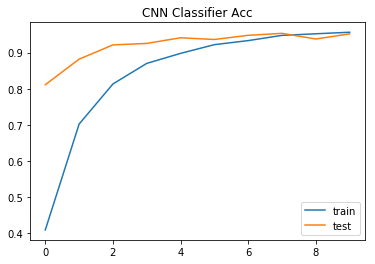

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('CNN Classifier Acc')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

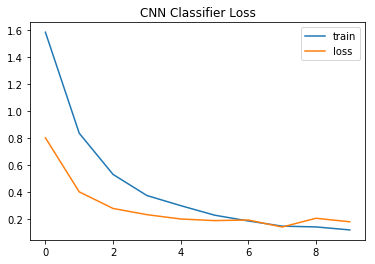

In [13]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('CNN Classifier Loss')
plt.legend(['train', 'loss'], loc='upper right')
plt.show()